In [41]:
from jaxgp.kernels import RBF
from jaxgp.regression import ExactGPRGrad, ExactGPR
from jaxgp.utils import Logger

import jax.numpy as jnp
import numpy as onp

import matplotlib.pyplot as plt

In [42]:
kbT = 2.4943387854
N_A = 6.02214076e23

flag_box = ["AA","AB","BB"]
data = onp.loadtxt("./NaCl_in_water_data.txt") # 7 columns: X_A S_AA S_AA_err S_AB S_AB_err S_BB S_BB_err

C_A  = data[:,0]
C_A_ratio = data[:,1]

M = data[:,2]

# for the structure factor S, save the data as a (2, N) array, the first coloumn is the value, while the second one is its error. 
S_AA = data[:,3]
S_AA_err = data[:,4]
S_AB = data[:,5]
S_AB_err = data[:,6]

In [43]:
def integrand_normal(ca, ratio, saa, sab):
    term = 1. / (saa - sab*jnp.sqrt(ratio)) - 1
    return term / ca

def integrand_log(ca, ratio, saa, sab):
    return 1. / (saa - sab*jnp.sqrt(ratio)) - 1

In [44]:
saa = jnp.array(S_AA)
sab = jnp.array(S_AB)
ca = jnp.array(C_A)
ratio = jnp.array(C_A_ratio)

In [45]:
from jaxgp import Optimizer

kernel = RBF(len(ca)+1)
# kernel = RBF()
noise = jnp.ones((len(ca),))*5e-1
noise = jnp.hstack((jnp.zeros(1), noise))
# noise = 5e-1
optimizer = Optimizer.LBFGSB

logger = Logger()

## Predict $\mu_A^{ex}$

In [46]:
# X_train = (jnp.zeros((1,1)), ca.reshape(-1,1))
# Y_train = integrand_normal(ca, ratio, saa, sab)*kbT
# Y_train = jnp.hstack((jnp.zeros(1), Y_train))

X_train = (jnp.ones((1,1))*(-2), jnp.log(ca).reshape(-1,1))
Y_train = integrand_log(ca, ratio, saa, sab)*kbT
Y_train = jnp.hstack((jnp.zeros(1), Y_train))

In [47]:
print(X_train[0].shape, X_train[1].shape)

(1, 1) (50, 1)


In [48]:
model = ExactGPR(kernel, noise=noise, logger=logger, optimize_method=optimizer)
# model = ExactGPR(kernel, logger=logger, optimize_method=optimizer, optimize_noise=True)

In [49]:
model.train(X_train, Y_train)

True


In [50]:
# model.kernel_params = jnp.ones_like(model.kernel_params)

In [51]:
eval_grid = jnp.log(jnp.sort(ca))

mean, std = model.eval(eval_grid.reshape(-1,1))
mu_a = mean.reshape(-1)
mu_a_err = std.reshape(-1)

Text(0, 0.5, '$\\mu^{ex}$')

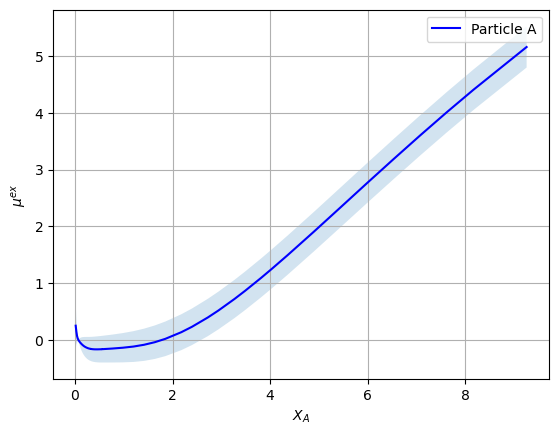

In [52]:
plt.plot(jnp.sort(M), mu_a, c="b", label="Particle A")
plt.fill_between(jnp.sort(M), mu_a-mu_a_err, mu_a+mu_a_err, alpha=0.2)

plt.grid()
plt.legend()

plt.xlabel("$X_A$")
plt.ylabel("$\mu^{ex}$")

In [53]:
jnp.savez("gp_predict_nacl.npz", mu_a=mu_a, mu_a_err=mu_a_err)